<a href="https://colab.research.google.com/github/shweta-aiml/100daysofcode/blob/master/hair_segmentation_using_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
from skimage import io

x_path = '/content/drive/My Drive/Figaro1k/Original/Training/'
y_path = '/content/drive/My Drive/Figaro1k/GT/Training/'
x_paths = os.listdir(x_path)
y_paths = os.listdir(y_path)
print("Count X:",len(x_paths))
print("Count Y:",len(y_paths))

Count X: 840
Count Y: 854


In [9]:
x_paths[0],y_paths[0]

('Frame00332-org.jpg', 'Frame00441-gt.pbm')

In [0]:
images,masks = [],[]
size = min(len(x_paths),len(y_paths))
for i in range(size):
    file = x_paths[i].replace('-org.jpg','')
    img_path = file + '-org.jpg'
    mask_path = file + '-gt.pbm'
    if img_path in x_paths and mask_path in y_paths:
      images.append( io.imread(x_path + img_path,plugin='matplotlib',as_gray = True) )
      masks.append( io.imread(y_path + mask_path,plugin='matplotlib',as_gray = True))
print("Actual data size:",len(images),len(masks))

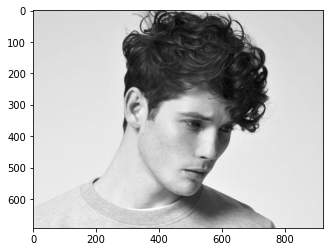

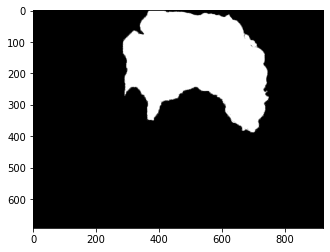

In [89]:
import matplotlib.pyplot as plt

def displayImage(img):
    plt.imshow(img,cmap='gray')
    plt.show()

idx = 50

img = images[idx]
displayImage(img)

img = masks[idx]
displayImage(img)

In [90]:
from skimage.transform import resize
np_images = np.zeros((size,224,224,1))
np_masks = np.zeros((size,224,224,1))

print("shape to be resized",np_images.shape)
print("Input images share" , img.shape)



shape to be resized (840, 224, 224, 1)
Input images share (692, 923)


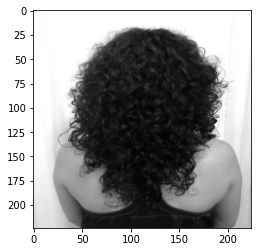

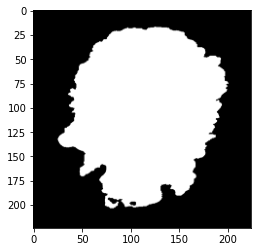

In [91]:
for i in range(size - 1):
    img = images[i]
    msk = masks[i]
    np_images[i] = resize(img,(224,224)).reshape((224,224,1))
    np_masks[i] = resize(msk,(224,224)).reshape((224,224,1))

sample = np_images[0].reshape((224,224))
displayImage(sample)

sample = np_masks[0].reshape((224,224))
displayImage(sample)

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks.callbacks import ReduceLROnPlateau

In [0]:
#U-UNET
inputs = Input((224, 224, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [94]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [95]:
epochs = 20
history = model.fit(np_images,np_masks,validation_split=0.05,epochs=epochs,batch_size=64,)
model.save('/content/sample_data/model.h5')

Train on 798 samples, validate on 42 samples
Epoch 1/20
798/798 [==============================] - 13s 16ms/step - loss: 0.3118 - acc: 0.6042 - val_loss: 0.2815 - val_acc: 0.6505
Epoch 2/20
798/798 [==============================] - 12s 15ms/step - loss: 0.2919 - acc: 0.6306 - val_loss: 0.2626 - val_acc: 0.6505
Epoch 3/20
798/798 [==============================] - 12s 15ms/step - loss: 0.2549 - acc: 0.6306 - val_loss: 0.2265 - val_acc: 0.6505
Epoch 4/20
798/798 [==============================] - 12s 15ms/step - loss: 0.2070 - acc: 0.6447 - val_loss: 0.1750 - val_acc: 0.6851
Epoch 5/20
798/798 [==============================] - 12s 15ms/step - loss: 0.1776 - acc: 0.6748 - val_loss: 0.1786 - val_acc: 0.6703
Epoch 6/20
798/798 [==============================] - 12s 15ms/step - loss: 0.1665 - acc: 0.7067 - val_loss: 0.1615 - val_acc: 0.7149
Epoch 7/20
798/798 [==============================] - 12s 15ms/step - loss: 0.1568 - acc: 0.7231 - val_loss: 0.1483 - val_acc: 0.7517
Epoch 8/20
798/79

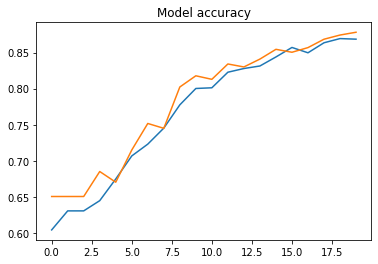

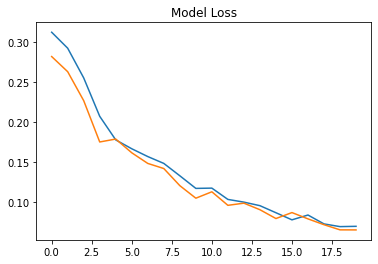

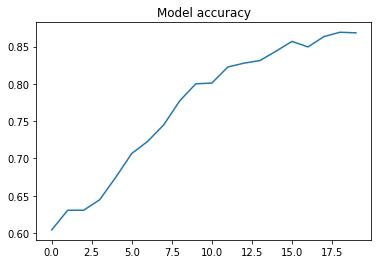

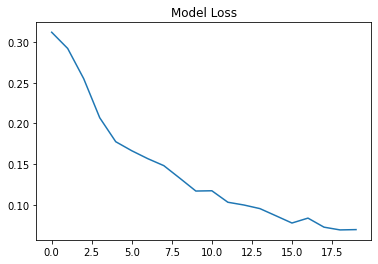

In [97]:
h = history
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

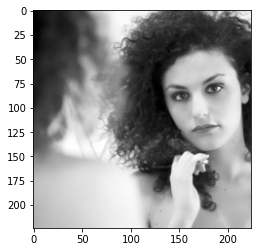

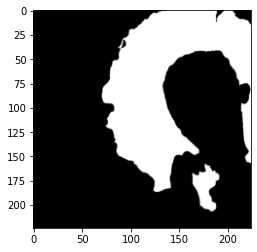

(224, 224, 1)


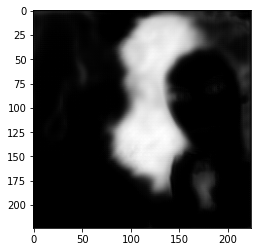

In [133]:
def predict(image):
    return model.predict(np.asarray([image]) ).reshape((224,224))
idx = 29
img = np_images[idx]
real = np_masks[idx]

displayImage(img.reshape((224,224)))
displayImage(real.reshape((224,224)))

print(img.shape)
pred = predict(img)
displayImage(pred)




In [117]:
from skimage import io

test_path = '/content/drive/My Drive/Figaro1k/Original/Testing/'
test_mask_path = '/content/drive/My Drive/Figaro1k/GT/Testing/'
test_paths = os.listdir(test_path)
test_mask_paths = os.listdir(test_mask_path)
print("Count X:",len(test_paths))
print("Count Y:",len(test_mask_paths))

Count X: 210
Count Y: 210


In [158]:
images,masks = [],[]
size = min(len(test_paths),len(test_mask_paths))
for i in range(size):
    file = test_paths[i].replace('-org.jpg','')
    img_path = file + '-org.jpg'
    mask_path = file + '-gt.pbm'
    if img_path in test_paths and mask_path in test_mask_paths:
      images.append( io.imread(test_path + img_path,plugin='matplotlib',as_gray = True) )
      masks.append( io.imread(test_mask_path + mask_path,plugin='matplotlib',as_gray = True))
print("Actual data size:",len(images),len(masks))

Actual data size: 210 210


In [164]:
size

210

In [168]:
len(images) ,len(masks)

(210, 210)

In [0]:
np_test_images = np.zeros((size,224,224,1))
np_test_masks = np.zeros((size,224,224,1))

for i in range(size):
    np_test_images[i] = resize(images[i],(224,224)).reshape((224,224,1))
    np_test_masks[i] = resize(masks[i],(224,224)).reshape((224,224,1))

    test_img = np_test_images[i].reshape((1,224,224,1))
    #displayImage(test_img)
    print(test_img.shape)
          
    test_msk = np_test_masks[i].reshape((1,224,224,1))
    #displayImage(sample)

    print('\n# Evaluate on test data')
    results = model.evaluate(test_img, test_msk, batch_size=128)
    print('test loss, test acc:', results)  

In [179]:
print('\n# Evaluate on test data')
results = model.evaluate(np_test_images, np_test_masks, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
210/210 [==============================] - 6s 29ms/step
test loss, test acc: [0.06381972985608238, 0.878156304359436]


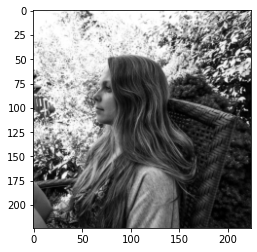

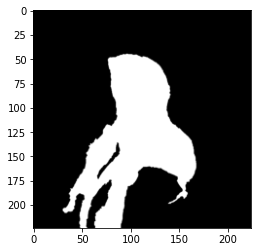

(224, 224, 1)


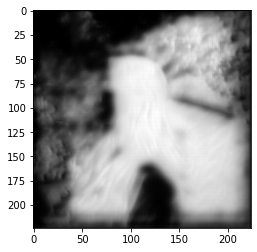

In [145]:
idx = 3
img = np_images[idx]
real = np_masks[idx]

displayImage(img.reshape((224,224)))
displayImage(real.reshape((224,224)))

print(img.shape)
pred = predict(img)
displayImage(pred)





In [0]:
for i in range(size - 1):
    img = images[i]
    msk = masks[i]
    np_images[i] = resize(img,(224,224)).reshape((224,224,1))
    np_masks[i] = resize(msk,(224,224)).reshape((224,224,1))

In [157]:
len(np_images)

840